### Prepare the data

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import ast

In [51]:
# Get the absolute path to the project root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))

# Prepare the data
data_hc = pd.read_csv(os.path.join(project_root, 'analysis_codebase', 'results', 'acw_results_1_archive', 'mean_acw_results_HC.csv'), header=0, names=['Subject', 'Region', 'ACW_50', 'ACW_0', 'ACW_Nadir'])
data_mdd = pd.read_csv(os.path.join(project_root, 'analysis_codebase', 'results', 'acw_results_1_archive', 'mean_acw_results_MDD.csv'), header=0, names=['Subject', 'Region', 'ACW_50', 'ACW_0', 'ACW_Nadir'])
data_sz = pd.read_csv(os.path.join(project_root, 'analysis_codebase', 'results', 'acw_results_1_archive', 'mean_acw_results_SZ.csv'), header=0, names=['Subject', 'Region', 'ACW_50', 'ACW_0', 'ACW_Nadir'])

# Add a 'Group' column to each dataframe
data_hc['Group'] = 'HC'
data_mdd['Group'] = 'MDD'
data_sz['Group'] = 'SZ'

# Combine all dataframes into one
combined_data = pd.concat([data_hc, data_mdd, data_sz], ignore_index=True)

# Melt the dataframe to long format
long_data = pd.melt(combined_data, id_vars=['Subject', 'Region', 'Group'], 
                    var_name='ACW_Type', value_name='ACW_Value')

# Save the combined long format dataframe
long_data.to_csv(os.path.join(project_root, 'analysis_codebase', 'results', 'combined_acw_results.csv'), index=False)

# Define outlier subjects
outlier_subjects = ['sub-005C', 'sub-004P', 'sub-035P', 'sub-051P']

# Remove outlier subjects from the dataframe
long_data_no_outliers = long_data[~long_data['Subject'].isin(outlier_subjects)]

# Save the long format dataframe without outliers
long_data_no_outliers.to_csv(os.path.join(project_root, 'analysis_codebase', 'results', 'combined_acw_results_no_outliers.csv'), index=False)

# Display the first few rows of both dataframes
print("Long data with outliers:")
print(long_data.head())
print("\nLong data without outliers:")
print(long_data_no_outliers.head())

# Print the number of subjects in each group before and after removing outliers
print("\nNumber of subjects in each group:")
print("Before removing outliers:")
print(long_data['Subject'].groupby(long_data['Group']).nunique())
print("\nAfter removing outliers:")
print(long_data_no_outliers['Subject'].groupby(long_data_no_outliers['Group']).nunique())


Long data with outliers:
    Subject    Region Group ACW_Type  ACW_Value
0  sub-009C  auditory    HC   ACW_50   2.000000
1  sub-005C    visual    HC   ACW_50   2.200000
2  sub-005C     motor    HC   ACW_50   2.000000
3  sub-005C       dmn    HC   ACW_50   2.333333
4  sub-005C       fpn    HC   ACW_50   2.500000

Long data without outliers:
     Subject    Region Group ACW_Type  ACW_Value
0   sub-009C  auditory    HC   ACW_50        2.0
7   sub-019C  auditory    HC   ACW_50        2.0
8   sub-006C    visual    HC   ACW_50        2.0
9   sub-006C     motor    HC   ACW_50        2.0
10  sub-006C       dmn    HC   ACW_50        2.0

Number of subjects in each group:
Before removing outliers:
Group
HC     21
MDD    21
SZ     19
Name: Subject, dtype: int64

After removing outliers:
Group
HC     20
MDD    18
SZ     19
Name: Subject, dtype: int64


### Plot the ACW Plots

In [52]:
def plot_acw(long_data, acw_type, output_folder, groups_to_plot, posthoc_file=None):
    """
    Create publication-ready ACW plots based on the specified ACW measure and add statistical significance markers.
    
    Parameters:
    - long_data (pd.DataFrame): The long-format dataframe containing ACW data
    - acw_type (str): The type of ACW measure to plot ('ACW_50', 'ACW_0', or 'ACW_Nadir')
    - output_folder (str): The folder path to save the output plots
    - groups_to_plot (list): List of groups to include in the plot (e.g., ['HC', 'SZ'])
    - posthoc_file (str, optional): Path to the CSV file containing post-hoc test results for significance markers
    
    Returns:
    - None (displays and saves the plots)
    """
    # Filter the data for the specified ACW type and groups
    plot_data = long_data[(long_data['ACW_Type'] == acw_type) & (long_data['Group'].isin(groups_to_plot))]
    
    # Set up the plot style
    plt.style.use('seaborn-whitegrid')
    sns.set_context("paper", font_scale=1.2)
    
    # Create the main figure with white background
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
    ax.set_facecolor('white')
    
    # Customize grid lines
    ax.grid(color='#E6E6E6', linestyle='-', linewidth=0.5)
    
    # Create the boxplot
    sns.boxplot(x='Region', y='ACW_Value', hue='Group', data=plot_data, 
                palette='Set2', width=0.7, ax=ax)
    
    # Add individual data points
    sns.stripplot(x='Region', y='ACW_Value', hue='Group', data=plot_data,
                  palette='Set2', size=4, jitter=True, dodge=True, ax=ax)
    
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[0:len(groups_to_plot)], 
              labels[0:len(groups_to_plot)],
              title='Group', title_fontsize=12, fontsize=10, loc='upper right')
    
    # Customize the plot
    ax.set_xlabel('Brain Region', fontsize=14, fontweight='bold')
    ax.set_ylabel('ACW Value', fontsize=14, fontweight='bold')
    
    # Format title without underscore
    title = acw_type.replace('_', ' ')
    ax.set_title(f'{title} Comparison Across Groups and Brain Regions', fontsize=16, fontweight='bold')
    
    # Rotate x-axis labels for better readability and set to ALL CAPS
    plt.xticks(rotation=45, ha='right')
    ax.set_xticklabels([label.get_text().upper() for label in ax.get_xticklabels()])
    
    # Add statistical significance markers if posthoc_file is provided
    if posthoc_file:
        posthoc_data = pd.read_csv(posthoc_file)
        regions = plot_data['Region'].unique()
        group_positions = {group: i for i, group in enumerate(groups_to_plot)}
        
        for region in regions:
            region_data = posthoc_data[posthoc_data['Region'] == region]
            significant_comparisons = region_data[
                (region_data['pval'] < 0.05) & 
                (region_data['A'].isin(groups_to_plot)) & 
                (region_data['B'].isin(groups_to_plot))
            ]
            
            if len(significant_comparisons) > 0:
                x = plot_data['Region'].unique().tolist().index(region)
                y_max = plot_data[plot_data['Region'] == region]['ACW_Value'].max()
                y_min = plot_data[plot_data['Region'] == region]['ACW_Value'].min()
                y_range = y_max - y_min
                
                for i, (_, comparison) in enumerate(significant_comparisons.iterrows()):
                    group_a, group_b = comparison['A'], comparison['B']
                    p_value = comparison['pval']
                    
                    y = y_max + (i + 1) * y_range * 0.08
                    
                    # Calculate x positions for the significance line
                    x1 = x - 0.2 + group_positions[group_a] * 0.3
                    x2 = x - 0.2 + group_positions[group_b] * 0.4
                    
                    # Draw the significance bar
                    ax.plot([x1, x2], [y, y], lw=1.5, c='k')
                    
                    if p_value < 0.001:
                        text = '***'
                    elif p_value < 0.01:
                        text = '**'
                    else:
                        text = '*'
                    ax.text((x1 + x2) / 2, y + y_range * 0.02, text, ha='center', va='bottom', color='k', fontsize=12)
    
    # Adjust layout and save the plot
    plt.tight_layout()
    groups_str = '_'.join(groups_to_plot)
    output_path = os.path.join(output_folder, f'{acw_type}_{groups_str}_comparison_plot.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    # Display the plot
    plt.show()
    
    print(f"Plot saved to: {output_path}")

/var/folders/bw/qbqmqjxs15q4f_vdkhzt40cc0000gn/T/ipykernel_35003/1945460543.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/var/folders/bw/qbqmqjxs15q4f_vdkhzt40cc0000gn/T/ipykernel_35003/1945460543.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label.get_text().upper() for label in ax.get_xticklabels()])


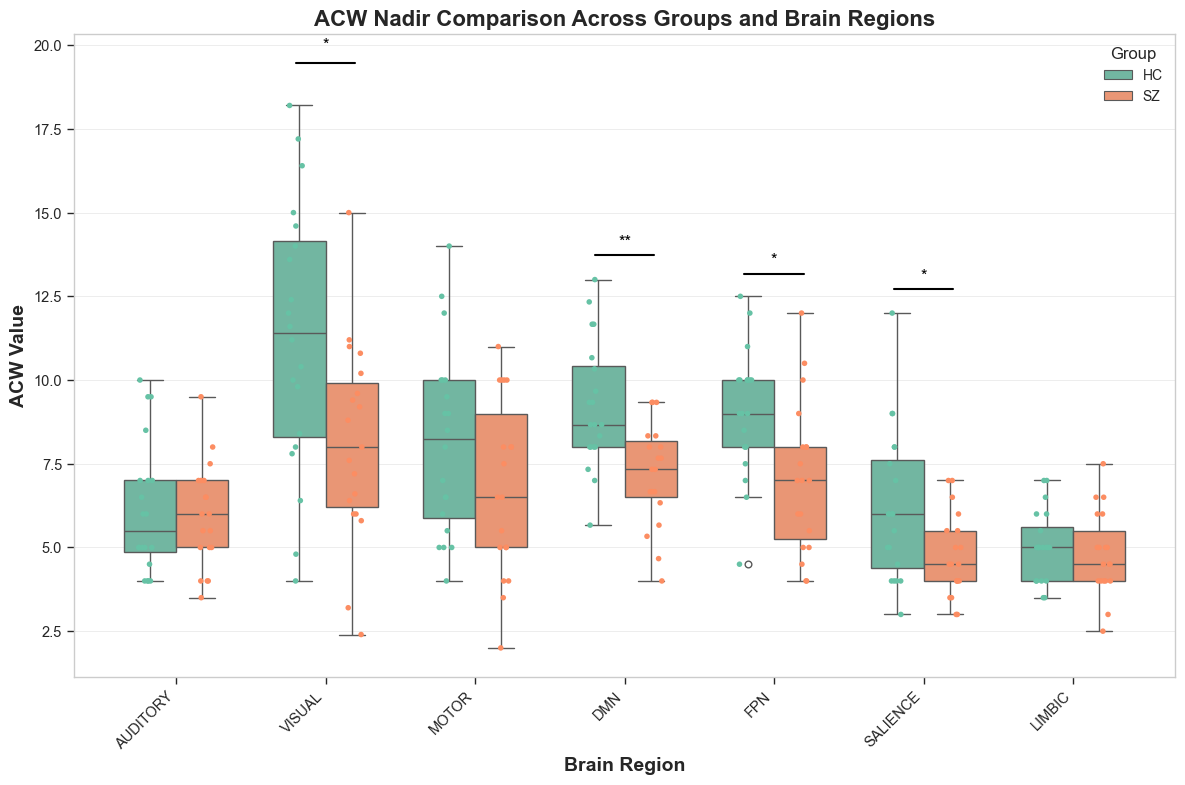

Plot saved to: /Users/fdjim/Desktop/PDS_CODE/analysis_codebase/results/plots/ACW_Nadir_HC_SZ_comparison_plot.png


In [53]:
# Example usage:
output_folder = os.path.join(project_root, 'analysis_codebase', 'results', 'plots')
os.makedirs(output_folder, exist_ok=True)

posthoc_file = os.path.join(project_root, 'analysis_codebase', 'results', 'post_hoc', 'post_hoc_Mean_ACW_Nadir.csv')

# Plot without outliers
plot_acw(long_data_no_outliers, 'ACW_Nadir', output_folder, ['HC', 'SZ'], posthoc_file=posthoc_file)

/var/folders/bw/qbqmqjxs15q4f_vdkhzt40cc0000gn/T/ipykernel_35003/1945460543.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/var/folders/bw/qbqmqjxs15q4f_vdkhzt40cc0000gn/T/ipykernel_35003/1945460543.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label.get_text().upper() for label in ax.get_xticklabels()])


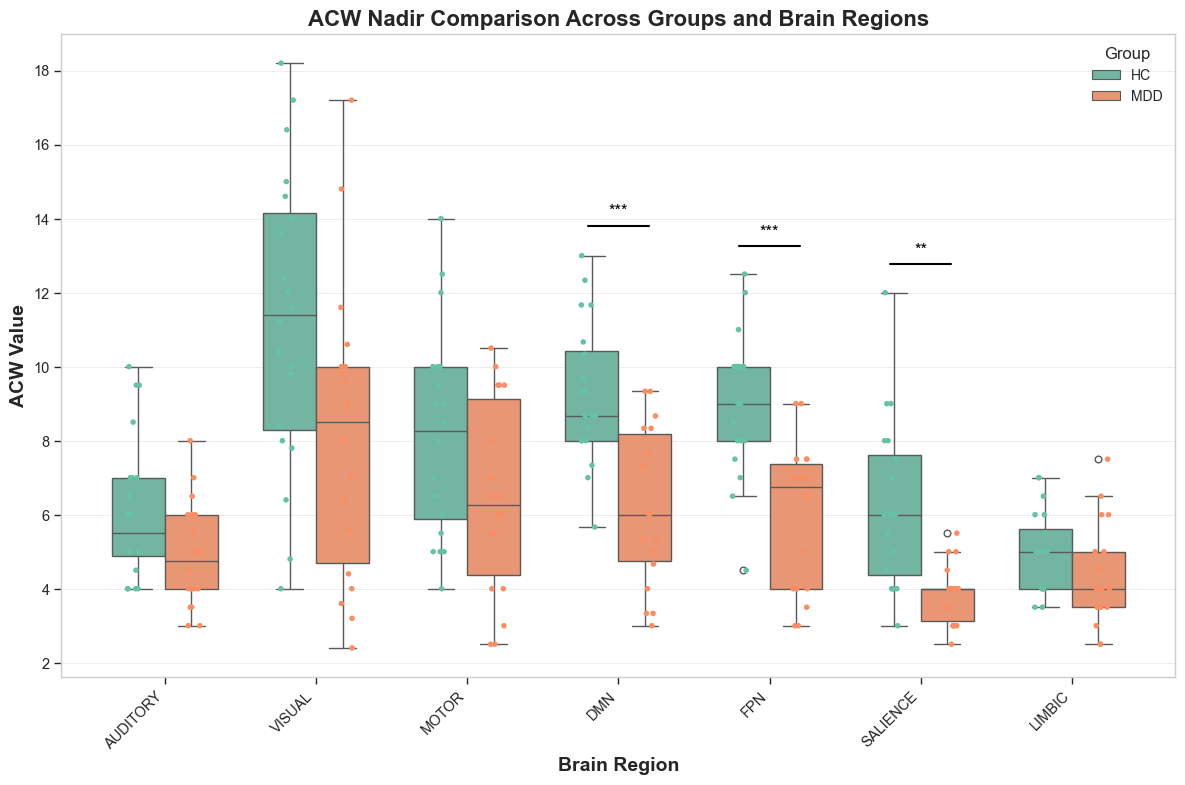

Plot saved to: /Users/fdjim/Desktop/PDS_CODE/analysis_codebase/results/plots/ACW_Nadir_HC_MDD_comparison_plot.png


In [57]:
# Example usage:
output_folder = os.path.join(project_root, 'analysis_codebase', 'results', 'plots')
os.makedirs(output_folder, exist_ok=True)

posthoc_file = os.path.join(project_root, 'analysis_codebase', 'results', 'post_hoc', 'post_hoc_Mean_ACW_Nadir.csv')

# Plot without outliers
plot_acw(long_data_no_outliers, 'ACW_Nadir', output_folder, ['HC', 'MDD'], posthoc_file=posthoc_file)

In [54]:
# # Example usage:
# output_folder = os.path.join(project_root, 'analysis_codebase', 'results', 'plots')
# os.makedirs(output_folder, exist_ok=True)

# posthoc_file = os.path.join(project_root, 'analysis_codebase', 'results', 'post_hoc', 'post_hoc_Mean_ACW_0.csv')

# # Create plots for each ACW measure with and without outliers
# for acw_type in ['ACW_0']:
#     # Plot with outliers
#     # plot_acw(long_data, acw_type, output_folder, posthoc_file=posthoc_file)
    
#     # Plot without outliers
#     plot_acw(long_data_no_outliers, acw_type, output_folder, posthoc_file=posthoc_file)

### Autocorrelation Function

In [55]:
def plot_average_acf_per_group(csv_files, groups, output_dir, acw_nadir_file, remove_outliers=False, outlier_subjects=None, max_seconds=20, tr=2.0):
    """
    Plots the average autocorrelation function for each group and region, limiting the x-axis to a specified number of seconds,
    and draws a vertical bar at the mean ACW nadir.
    
    Parameters:
    - csv_files (dict): Dictionary mapping group names to their respective CSV file paths.
    - groups (list): List of group names.
    - output_dir (str): Directory where the plots will be saved.
    - acw_nadir_file (str): Path to the CSV file containing ACW nadir data.
    - remove_outliers (bool): If True, removes outlier subjects from the plot.
    - outlier_subjects (list): List of subject IDs to be removed if remove_outliers is True.
    - max_seconds (float): Maximum number of seconds to display on the x-axis.
    - tr (float): Repetition time in seconds.
    """
    # Initialize an empty DataFrame
    all_data = pd.DataFrame()

    # Read and combine data from all groups
    for group in groups:
        file_path = csv_files[group]
        df = pd.read_csv(file_path, header=None, names=['Subject', 'Region', 'Autocorr'])
        df['Group'] = group
        all_data = pd.concat([all_data, df], ignore_index=True)

    # Remove outliers if specified
    if remove_outliers and outlier_subjects:
        all_data = all_data[~all_data['Subject'].isin(outlier_subjects)]

    # Read ACW nadir data
    acw_nadir_data = pd.read_csv(acw_nadir_file)
    if remove_outliers and outlier_subjects:
        acw_nadir_data = acw_nadir_data[~acw_nadir_data['Subject'].isin(outlier_subjects)]

    # Function to parse the Autocorr column
    def parse_autocorr(acf_str):
        try:
            acf_str = acf_str.replace('array(', '').replace(')', '')
            return ast.literal_eval(acf_str)
        except Exception as e:
            print(f"Error parsing Autocorr data: {e}")
            return []

    # Apply parsing to the Autocorr column
    all_data['Autocorr'] = all_data['Autocorr'].apply(parse_autocorr)

    # Get the list of unique regions
    regions = all_data['Region'].unique()

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Calculate the number of lags corresponding to max_seconds + 2 (to include the last value)
    max_lag = int((max_seconds + 2) / tr)

    # Iterate over each region
    for region in regions:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
        fig.suptitle(f'Autocorrelation Function - {region}', fontsize=16)
        
        # Iterate over each group
        for i, group in enumerate(groups):
            group_data = all_data[(all_data['Group'] == group) & (all_data['Region'] == region)]
            
            if group_data.empty:
                continue
            
            all_acfs = []
            
            # Plot each subject's ACF
            for idx, row in group_data.iterrows():
                acfs = row['Autocorr']
                for acf in acfs:
                    axs[i].plot(np.arange(len(acf[:max_lag])) * tr, acf[:max_lag], color='blue', alpha=0.2)
                    all_acfs.append(acf[:max_lag])
            
            # Calculate and plot the average ACF
            if all_acfs:
                mean_acf = np.mean(all_acfs, axis=0)
                axs[i].plot(np.arange(len(mean_acf)) * tr, mean_acf, color='red', alpha=1.0, linewidth=2, label='Average')
                        
            axs[i].set_title(f'{group}')
            axs[i].set_xlabel('Time (seconds)')
            axs[i].set_ylabel('Autocorrelation')
            
            # Set x-axis ticks and limits
            axs[i].set_xticks(np.arange(0, max_seconds, 2))
            axs[i].set_xlim(0, max_seconds)
            
            axs[i].legend()
        
        # Adjust layout and save the plot
        plt.tight_layout()
        plot_path = os.path.join(output_dir, f'ACF_{region}.png')
        plt.savefig(plot_path, dpi=300)
        plt.close()
        print(f"Plot saved to: {plot_path}")

In [56]:
csv_files = {
    'HC': os.path.join(project_root, 'analysis_codebase', 'results', 'acf_results_HC.csv'),
    'SZ': os.path.join(project_root, 'analysis_codebase', 'results', 'acf_results_SZ.csv'),
    'MDD': os.path.join(project_root, 'analysis_codebase', 'results', 'acf_results_MDD.csv')
}

groups = ['HC', 'SZ', 'MDD']
output_dir = os.path.join(project_root, 'analysis_codebase', 'results', 'acf_plots')

# Define outlier subjects
outlier_subjects = ['sub-005C', 'sub-004P', 'sub-035P', 'sub-051P']

acw_nadir_file = os.path.join(project_root, 'analysis_codebase', 'results', 'combined_acw_results_no_outliers.csv')

# Plot without outliers, limiting to 10 seconds, with TR of 0.72 seconds
plot_average_acf_per_group(csv_files, groups, output_dir, acw_nadir_file, remove_outliers=True, outlier_subjects=outlier_subjects, max_seconds=20, tr=2.0)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/fdjim/Desktop/PDS_CODE/analysis_codebase/results/acf_results_HC.csv'